# **Laboratorio 11 - Proyecto de Consultoría - SparkML**


- Mónica Salvatierra 22249
- Derek Arreaga 22537

Link del repositorio: https://github.com/alee2602/LAB11-DS

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, stddev, min as min_, max as max_
from pyspark.sql.functions import sum as _sum, when
import seaborn as sns
import matplotlib.pyplot as plt

### **Iniciar sesión en Spark**

In [6]:


spark = (
    SparkSession.builder
    .appName("Churn-LogReg")
    .getOrCreate()
)

spark


### **Carga de datos**

In [16]:

path_hist = "abandono_clientes.csv"   # histórico CON columna 'Churn'
path_new  = "clientes_nuevos.csv"     # futuros SIN 'Churn'

df_hist = spark.read.csv(path_hist, header=True, inferSchema=True)
df_new  = spark.read.csv(path_new,  header=True, inferSchema=True)

print("Histórico (con etiqueta):", df_hist.count(), "filas")
print("Nuevos (sin etiqueta):",   df_new.count(),  "filas")

df_hist.printSchema()
df_hist.show(5, truncate=False)


Histórico (con etiqueta): 900 filas
Nuevos (sin etiqueta): 6 filas
root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------------------------------------+---------------------------+-----+
|Names           |Age |Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date       |Location                                          |Company                    |Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------------------------------------+--------------------------

### **Observar la existencia de valores nulos y balanceo entre clases**

In [17]:

# Nulos por columna
nulls = df_hist.select([_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_hist.columns])
nulls.show(truncate=False)

# Balance de clases 
if "Churn" in df_hist.columns:
    df_hist.groupBy("Churn").count().show()

+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+
|Names|Age|Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date|Location|Company|Churn|
+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+
|0    |0  |0             |0              |0    |0        |0           |0       |0      |0    |
+-----+---+--------------+---------------+-----+---------+------------+--------+-------+-----+

+-----+-----+
|Churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



No existen valores nulos en los datos históricos. Sin embargo, las clases se encuentran desbalanceadas. Se podría utilizar la técnica de SMOTE al momento de realizar el modelo.

### **Resumen estadístico de las variables numéricas**

In [19]:

numeric_cols = [c for c, t in df_hist.dtypes if t in ("double", "int") and c != "Churn"]

stats = df_hist.select(
    *[min_(col(c)).alias(f"{c}_min") for c in numeric_cols],
    *[max_(col(c)).alias(f"{c}_max") for c in numeric_cols],
    *[avg(col(c)).alias(f"{c}_mean") for c in numeric_cols],
    *[stddev(col(c)).alias(f"{c}_std") for c in numeric_cols]
)
stats.show(truncate=False)

+-------+------------------+-------------------+---------+-------------+-------+------------------+-------------------+---------+-------------+-----------------+-------------------+--------------------+----------------+-----------------+-----------------+------------------+-------------------+-----------------+------------------+
|Age_min|Total_Purchase_min|Account_Manager_min|Years_min|Num_Sites_min|Age_max|Total_Purchase_max|Account_Manager_max|Years_max|Num_Sites_max|Age_mean         |Total_Purchase_mean|Account_Manager_mean|Years_mean      |Num_Sites_mean   |Age_std          |Total_Purchase_std|Account_Manager_std|Years_std        |Num_Sites_std     |
+-------+------------------+-------------------+---------+-------------+-------+------------------+-------------------+---------+-------------+-----------------+-------------------+--------------------+----------------+-----------------+-----------------+------------------+-------------------+-----------------+------------------+
|22.

### **Distribución de las variables numéricas**

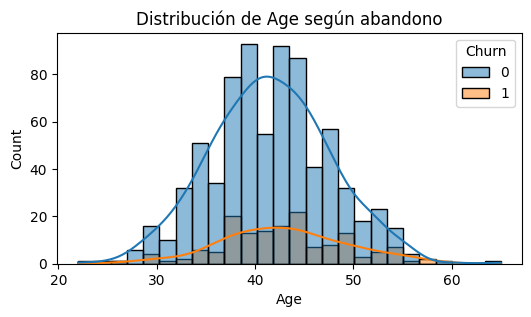

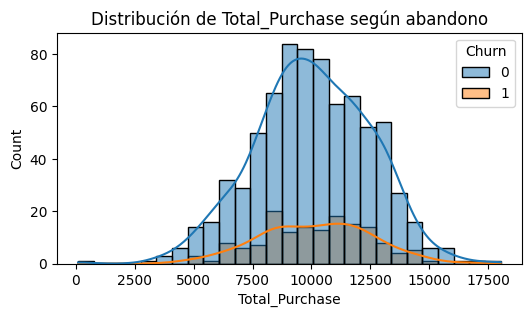

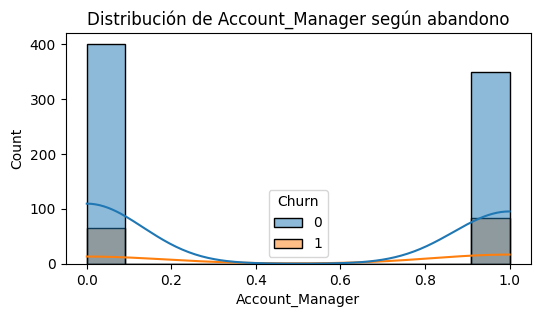

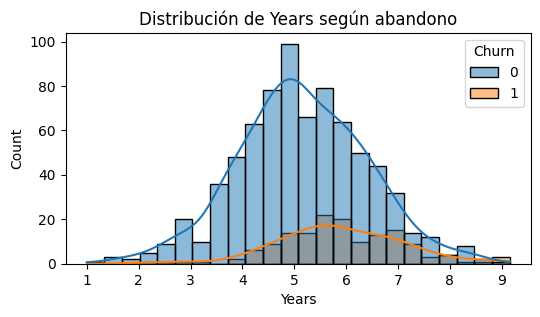

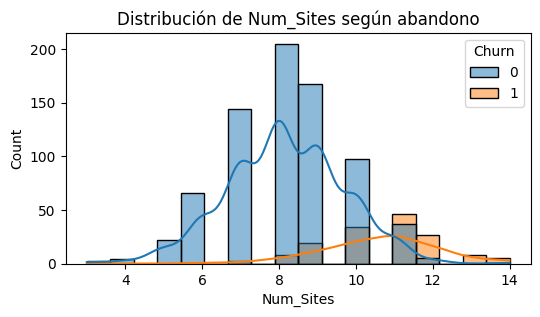

In [20]:

pdf = df_hist.toPandas()

for col_name in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(data=pdf, x=col_name, hue="Churn", kde=True)
    plt.title(f"Distribución de {col_name} según abandono")
    plt.show()


### **Matriz de correlación**

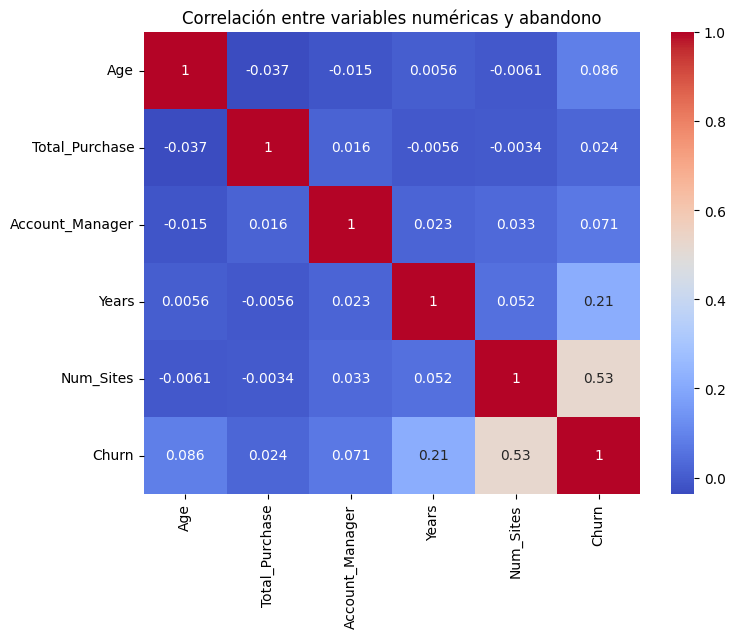

Churn              1.000000
Num_Sites          0.525398
Years              0.214329
Age                0.085926
Account_Manager    0.070611
Total_Purchase     0.024031
Name: Churn, dtype: float64


In [13]:

corr = pdf[numeric_cols + ["Churn"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Correlación entre variables numéricas y abandono")
plt.show()

print(corr["Churn"].sort_values(ascending=False))


### **DIvisión de datos y pipeline del modelo**

1. Usar los datos históricos para entrenar el modelo del predicción de clasificación
2. Aplicar el modelo en los clientes nuevos para predecir la probabilidad de abandono
3. Para modelos predicitvos, podemos usar ya sea Random Forest o si se quiere un modelo más simple, una regresión logística
4. Como las clases se encuntran desbalanceadas, no tomar en cuenta el accuracy como métrica principal